In [189]:
%matplotlib widget
from mmdet3d.datasets import build_dataset
from tools.misc.browse_dataset import build_data_cfg
from mmdet3d.models import apply_3d_transformation
import matplotlib.pyplot as plt
import copy
import torch
import numpy as np
from mmdet3d.ops.voxel.voxelize import voxelization

In [190]:
config = "configs/_base_/datasets/nus-3d-1sweep-remove_close_develop_single.py"

In [191]:
config = "configs/_base_/datasets/nus-3d-1sweep-remove_close_develop_single.py"
cfg = build_data_cfg(config, ["Normalize"], None)
try:
    dataset = build_dataset(cfg.data.train, default_args=dict(filter_empty_gt=False))
except TypeError:  # seg dataset doesn't have `filter_empty_gt` key
    dataset = build_dataset(cfg.data.train)

In [192]:
def proj_points_to_2d(points, proj_mat):
    points = np.concatenate([points[:, :3].reshape(-1, 3), np.ones((points.shape[0], 1))], axis=-1)    
    points_2d = points @ proj_mat.T
    points_2d[:, 2] = np.clip(points_2d[:, 2], a_min=1e-5, a_max=1e5)
    points_2d[:, 0] /= points_2d[:, 2]
    points_2d[:, 1] /= points_2d[:, 2]
    return points_2d

def proj_point_to_2d(point, proj_mat):
    point = np.concatenate([point, [1]], axis=-1)    
    point_2d = point @ proj_mat.T
    point_2d[2] = np.clip(point_2d[2], a_min=1e-5, a_max=1e5)
    point_2d[0] /= point_2d[2]
    point_2d[1] /= point_2d[2]
    return point_2d

def get_rgb(img):
    # Convert img to RGB
    img = img.int()
    img = img.flip(0) # BGR image, flip to RGB
    return img.permute(1, 2, 0) # Permute to (H, W, C)

### Build dataset from config

In [193]:
config = "configs/_base_/datasets/nus-3d-1sweep-remove_close_develop_single.py"
cfg = build_data_cfg(config, ["Normalize"], None)
try:
    dataset = build_dataset(cfg.data.train, default_args=dict(filter_empty_gt=False))
except TypeError:  # seg dataset doesn't have `filter_empty_gt` key
    dataset = build_dataset(cfg.data.train)

### Read data sample

In [194]:
cam_idx = 0
sample = dataset[0]
img_metas = sample["img_metas"].data
points = sample["points"].data
imgs = sample["img"].data
img = imgs[cam_idx]
proj_mat = img_metas['lidar2img'][cam_idx]

### Project lidar points to img

In [195]:
proj_mat = copy.deepcopy(proj_mat).reshape(4, 4)
if isinstance(proj_mat, torch.Tensor):
    proj_mat = proj_mat.cpu().numpy()

points_2d = proj_points_to_2d(points, proj_mat)

is_point_in_image = [(0 <= p[0] <= 1600) and (0 <= p[1] <= 900) for p in points_2d] 
points_2d_in_image = points_2d[is_point_in_image, :]
points_3d_in_image = points[is_point_in_image, :]

### Plot img and lidar points

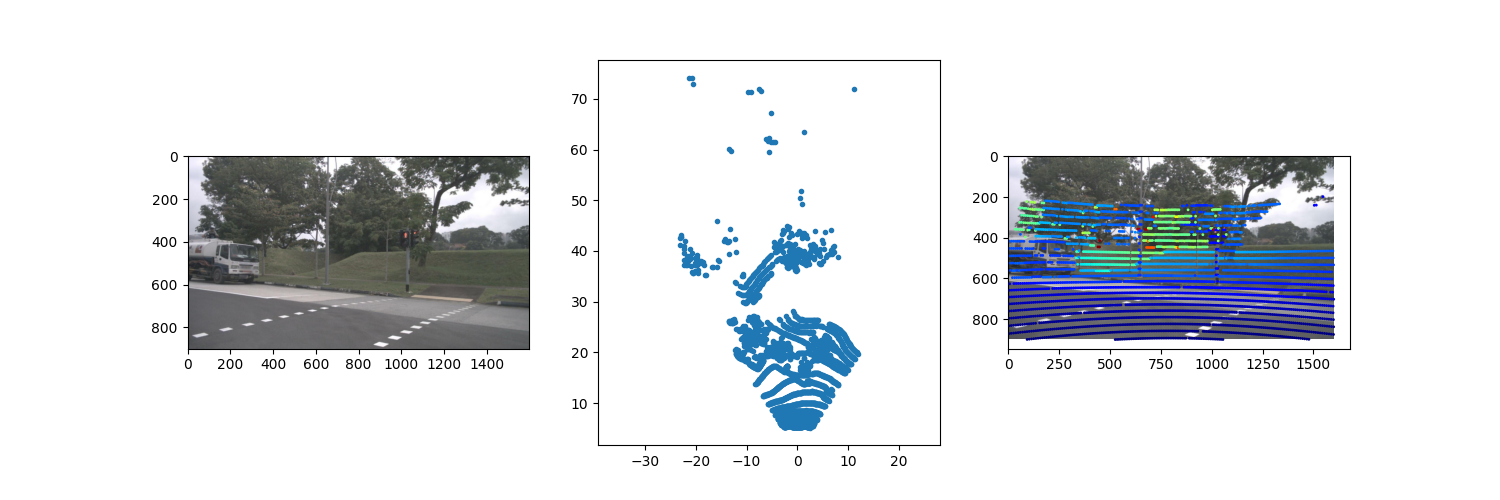

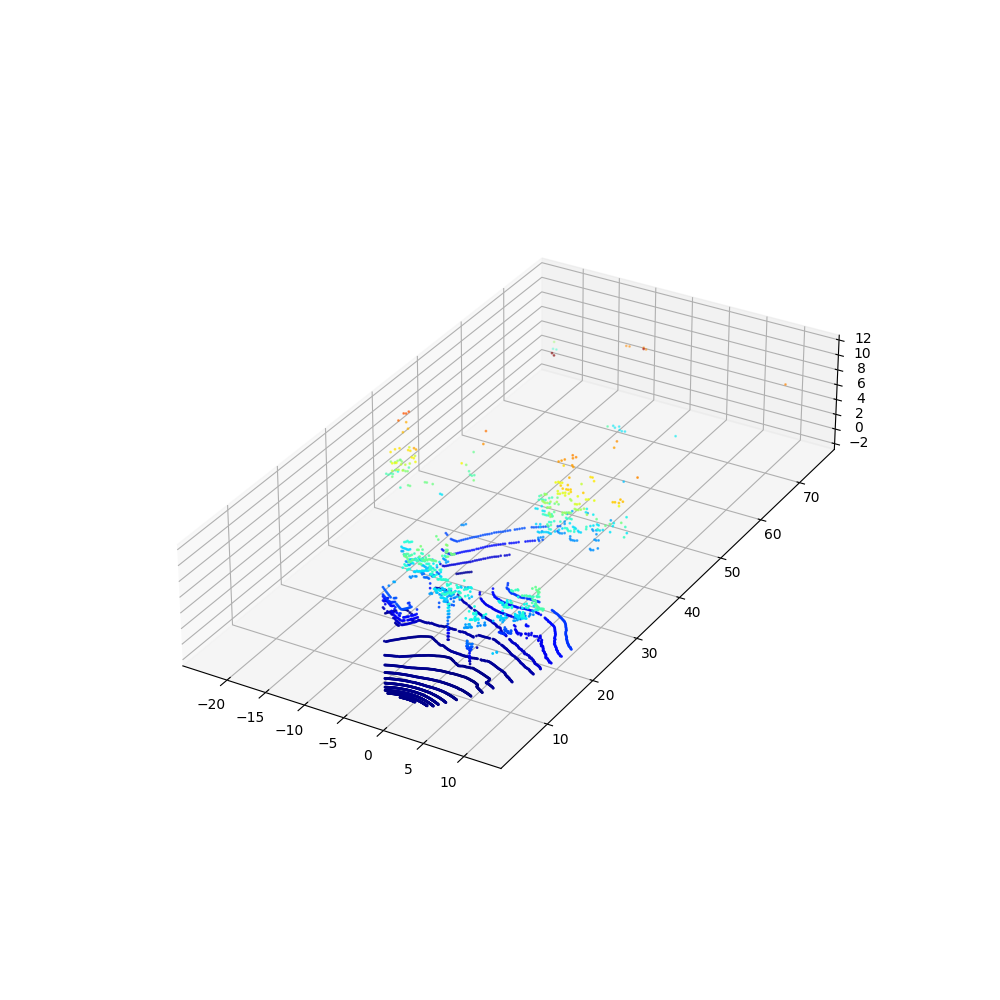

In [196]:
# Create subplot with rgb image, 3d points and projected lidar points
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb)
ax[1].plot(points_3d_in_image[:, 0], points_3d_in_image[:, 1], ".")
ax[1].axis("equal")
ax[2].imshow(rgb)
ax[2].scatter(points_2d_in_image[:, 0], points_2d_in_image[:, 1], s=1, c=points_2d_in_image[:, 2], cmap="jet")
plt.show()

# Create 3d plot of lidar points
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_in_image[:, 0], points_3d_in_image[:, 1], points_3d_in_image[:, 2], s=1, c=points_3d_in_image[:, 2], cmap="jet")
ax.set_box_aspect((np.ptp(points_3d_in_image[:, 0]), np.ptp(points_3d_in_image[:, 1]), np.ptp(points_3d_in_image[:, 2])))
plt.show()


### Voxelize point cloud

In [197]:
voxel_size = 1.0
r = 50
point_cloud_range = (-r, -r, -5, r, r, 3)
voxels, voxel_coors, num_points_per_voxel = voxelization(points, (voxel_size, voxel_size, 8), point_cloud_range)
n_voxels_x = (point_cloud_range[3] - point_cloud_range[0])/voxel_size

### Plot voxel grid and non-empty voxels

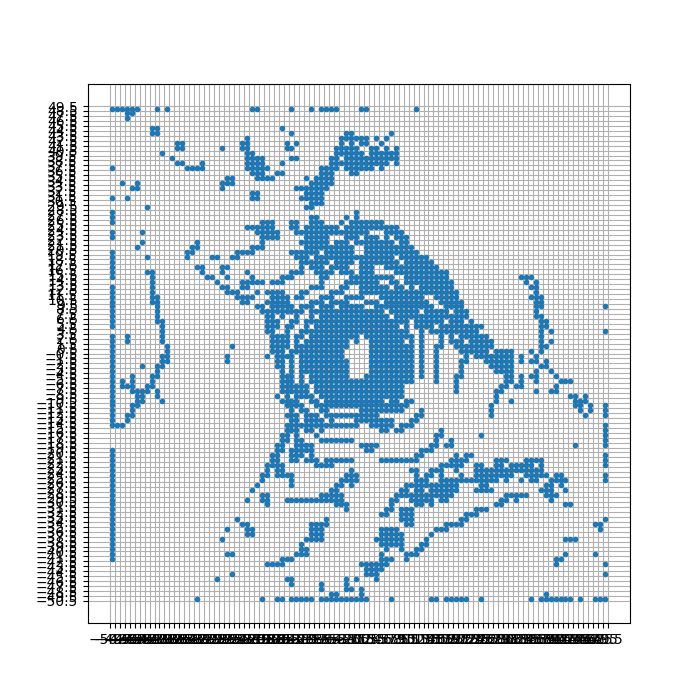

In [198]:
plt.figure(figsize=(7, 7))
plt.plot(voxel_coors[:, 2]-n_voxels_x/2, voxel_coors[:, 1]-n_voxels_x/2, ".")
plt.xticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.yticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
plt.grid(True, which='major')
plt.show()

### Lidar points visible in different camera views

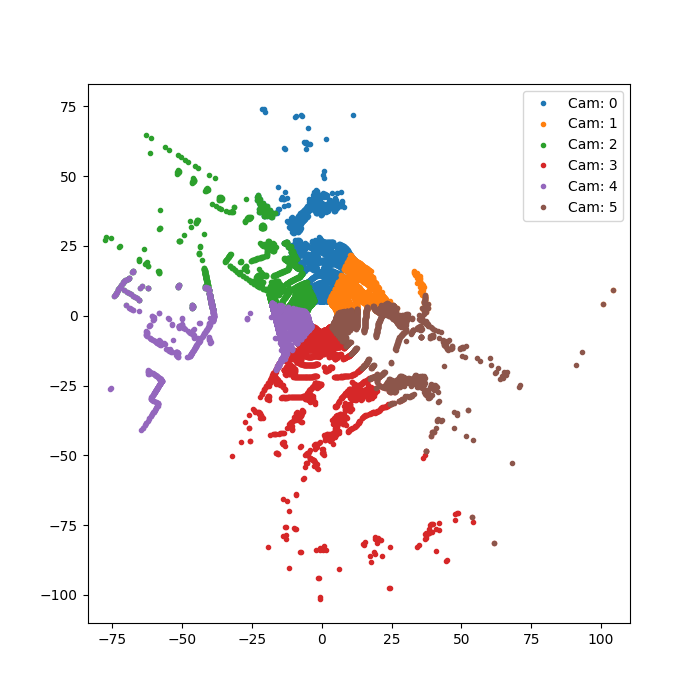

In [199]:

plt.figure(figsize=(7, 7))

sample = dataset[0]
points = sample["points"].data
img_metas = sample["img_metas"].data
for cam_idx in range(6):
    proj_mat = img_metas['lidar2img'][cam_idx]
    
    proj_mat = copy.deepcopy(proj_mat).reshape(4, 4)
    if isinstance(proj_mat, torch.Tensor):
        proj_mat = proj_mat.cpu().numpy()
        
    points_2d = proj_points_to_2d(points, proj_mat)

    is_point_in_image = [(0 <= p[0] <= 1600) and (0 <= p[1] <= 900) for p in points_2d] 
    points_3d_in_image = points[is_point_in_image, :]
    
    plt.plot(points_3d_in_image[:, 0], points_3d_in_image[:, 1], ".", label=f"Cam: {cam_idx}")

    
plt.axis("equal")
plt.legend()
plt.show()

# Reset cam idx to front
cam_idx = 0
img = imgs[cam_idx]
proj_mat = img_metas['lidar2img'][cam_idx]

### Front cam voxels

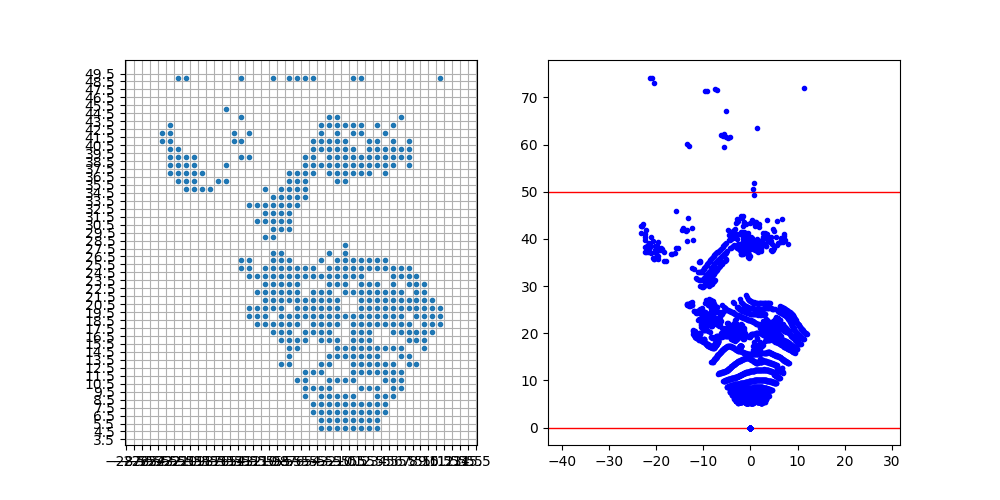

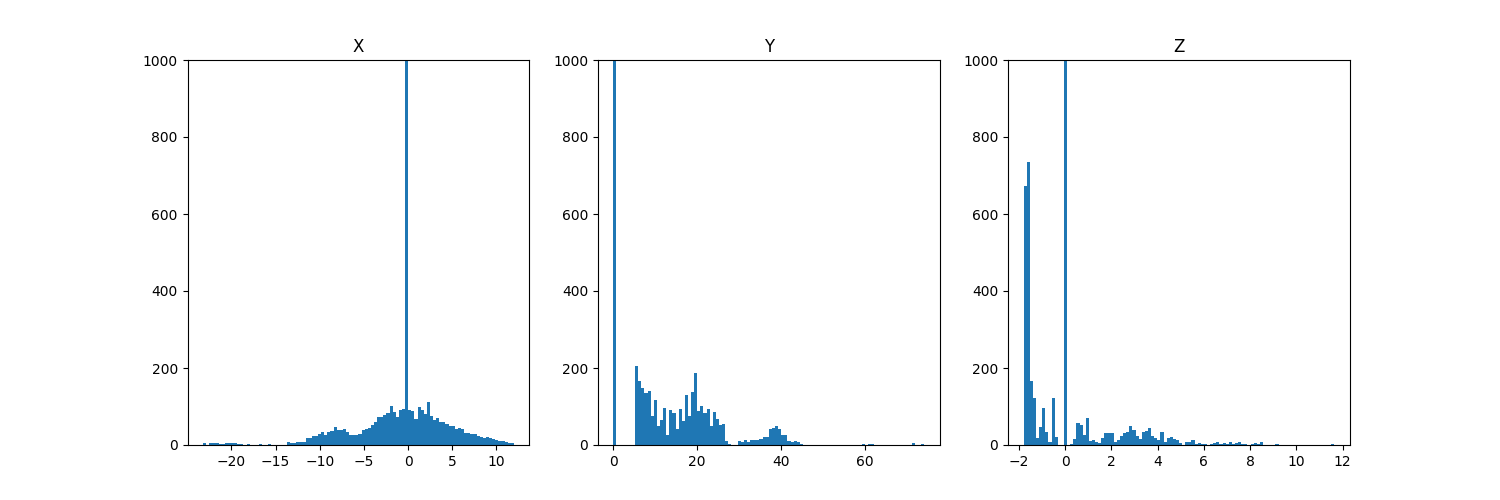

In [200]:
from matplotlib import patches

# Projection points to 2d
proj_mat = copy.deepcopy(proj_mat).reshape(4, 4)
if isinstance(proj_mat, torch.Tensor):
    proj_mat = proj_mat.cpu().numpy()

points_2d = proj_points_to_2d(points, proj_mat)

is_point_in_image = [(0 <= p[0] <= 1600) and (0 <= p[1] <= 900) for p in points_2d] 
points_2d_in_image = points_2d[is_point_in_image, :]
points_3d_in_image = points[is_point_in_image, :]

# Voxelize
voxel_size = 1.0
r = 50
point_cloud_range = (-r, 0, -5, r, r, 3)
voxels, voxel_coors, num_points_per_voxel = voxelization(points_3d_in_image, (voxel_size, voxel_size, 8), point_cloud_range)
n_voxels_x = (point_cloud_range[3] - point_cloud_range[0])/voxel_size

# Create two subplots of voxel grid and voxel points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(voxel_coors[:, 2]-n_voxels_x/2, voxel_coors[:, 1], ".")
ax1.set_xticks(np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1) - 0.5)
ax1.set_yticks(np.arange(0, n_voxels_x/2 + 1, 1) - 0.5)
ax1.grid(True, which='major')
ax1.axis("equal")

ax2.plot(voxels[:, :, 0], voxels[:, :, 1], ".", c="b")
ax2.axis("equal")
# Plot square for the point cloud range
ax2.add_patch(
    patches.Rectangle(
        (point_cloud_range[0], point_cloud_range[1]),
        point_cloud_range[3]-point_cloud_range[0],
        point_cloud_range[4]-point_cloud_range[1],
        linewidth=1, edgecolor='r', facecolor='none'
    )
)
plt.show()


# Create subplots with histograms for x, y, z in voxels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(voxels[:, :, 0].flatten(), bins=100)
ax1.set_title("X")
ax1.set_ylim(0, 1000)
ax2.hist(voxels[:, :, 1].flatten(), bins=100)
ax2.set_title("Y")
ax2.set_ylim(0, 1000)
ax3.hist(voxels[:, :, 2].flatten(), bins=100)
ax3.set_title("Z")
ax3.set_ylim(0, 1000)
plt.show()


### Voxel projection methods
- Center of mass (avg(x), avg(y), avg(z) or median)
- Voting strategy (choose the window where most of the points end up)
- Projection of all points (voxel feature end up in all windows that points project to)
- Center coordinate
- Corners of the voxel

In [201]:
def center_of_mass(voxel):
    non_zero_points = sum([ point.any() for point in voxel ])

    if non_zero_points == 0:
        return np.array([0, 0, 0])

    voxel_mean_x = voxel[:, 0].sum() / non_zero_points
    voxel_mean_y = voxel[:, 1].sum() / non_zero_points
    voxel_mean_z = voxel[:, 2].sum() / non_zero_points

    return np.array([voxel_mean_x, voxel_mean_y, voxel_mean_z])

#### Creating voxel grid data structure for easier plotting of selected voxels

In [202]:
# Create voxel grid
n_voxels_y = n_voxels_x
n_voxels_z = 1
voxel_grid = np.zeros((int(n_voxels_x), int(n_voxels_y), int(n_voxels_z), voxels.shape[1], voxels.shape[2]))

# Fill voxel grid with voxels
for i in range(voxel_coors.shape[0]):
    voxel_grid[voxel_coors[i, 2], voxel_coors[i, 1], voxel_coors[i, 0], :, :] = voxels[i, :, :]


#### Clickable plot for visualizing projection of different voxels

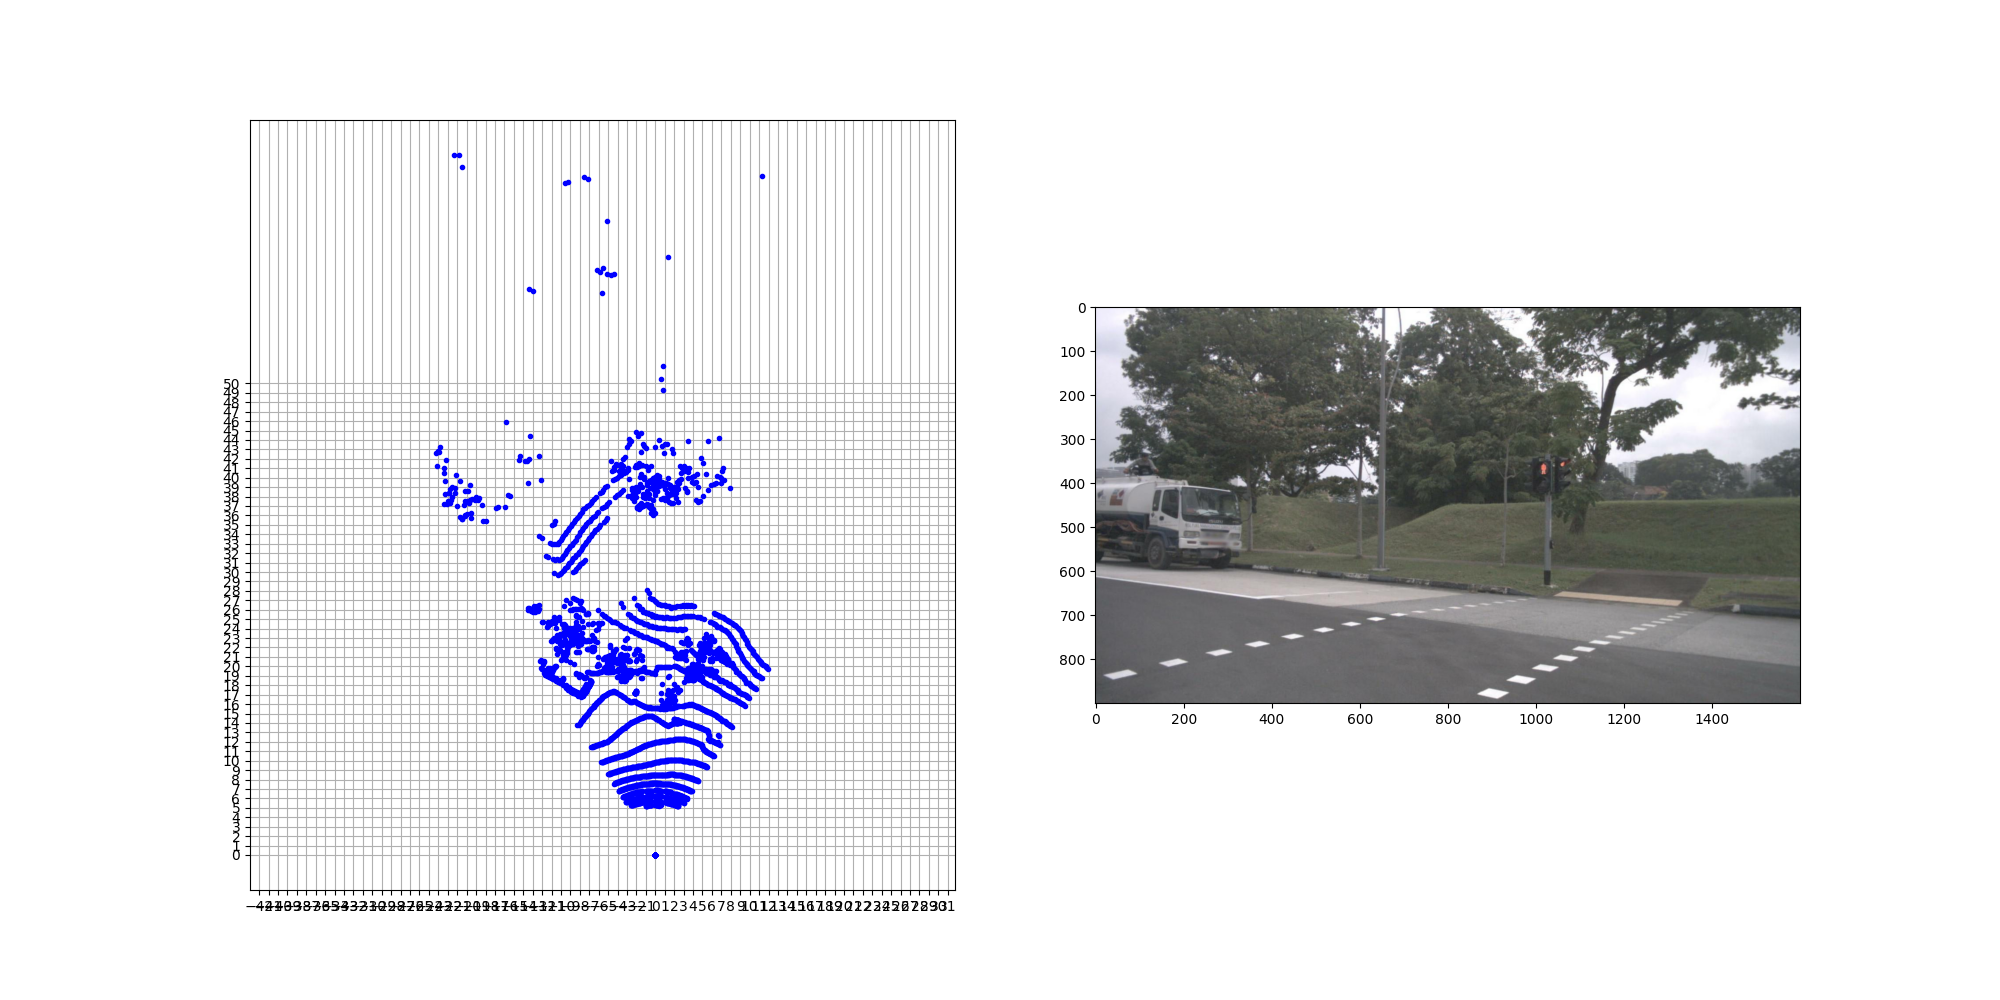

In [203]:
# Plot grid lines
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].set_xticks( voxel_size * (np.arange(-n_voxels_x/2, n_voxels_x/2 + 1, 1)) )
axs[0].set_yticks( voxel_size * (np.arange(0, n_voxels_x/2 + 1, 1)) )
axs[0].grid(True, which='major')
axs[0].axis("equal")

# Plot voxel points stored in voxel grid
for i in range(voxel_grid.shape[0]):
    for j in range(voxel_grid.shape[1]):
        for k in range(voxel_grid.shape[2]):
            voxel = voxel_grid[i, j, k, :, :]
            axs[0].plot(voxel[:, 0], voxel[:, 1], ".", c="b")

axs[1].imshow(rgb)

# Create clickable plot
def onclick(event):
    x = event.xdata
    y = event.ydata

    # Closest voxel coordinate
    x = int(np.floor(x))
    y = int(np.floor(y))
    
    # Get voxel
    vx = x + int(n_voxels_x/2)
    vy = y #+ int(n_voxels_y/2)
    voxel = voxel_grid[vx, vy, 0, :, :]

    # Get non-zero points in voxel
    voxel = voxel[voxel.any(axis=1)]

    # Plot mark in center of voxel
    x = x + voxel_size/2
    y = y + voxel_size/2
    axs[0].plot(x, y, "x", c="r")
    
    # Plot voxel points
    axs[0].plot(voxel[:, 0], voxel[:, 1], ".", c="r")

    # Compute center of mass
    if voxel.any():
        # Project voxel points to 2D
        voxel_2d = proj_points_to_2d(voxel, proj_mat)
        axs[1].plot(voxel_2d[:, 0], voxel_2d[:, 1], ".", c="b")

        # Compute center of mass
        voxel_com = center_of_mass(voxel)
        axs[0].plot(voxel_com[0], voxel_com[1], "o", c="g")

        # Project center of mass to 2D
        voxel_com_2d = proj_point_to_2d(voxel_com, proj_mat)
        axs[1].plot(voxel_com_2d[0], voxel_com_2d[1], "o", c="g")


    fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()



In [204]:
print(points[0])
print(voxel_grid[int(n_voxels_x/2), 6, 0, :, :])

tensor([-3.1790, -0.1481, -1.8945,  0.0000])
[[ 1.98707520e-03  6.24150276e+00 -1.67156899e+00  0.00000000e+00]
 [ 3.80377984e-03  6.84524632e+00 -1.65536320e+00  0.00000000e+00]
 [ 3.87324840e-02  6.24358845e+00 -1.67206478e+00  0.00000000e+00]
 [ 4.27718125e-02  6.84340143e+00 -1.65489304e+00  0.00000000e+00]
 [ 7.43680820e-02  6.24541235e+00 -1.67256165e+00  0.00000000e+00]
 [ 8.29778612e-02  6.84133196e+00 -1.65442240e+00  0.00000000e+00]
 [ 1.12219401e-01  6.24128389e+00 -1.67154062e+00  0.00000000e+00]
 [ 1.24404140e-01  6.84097672e+00 -1.65441155e+00  0.00000000e+00]
 [ 1.49908945e-01  6.23490858e+00 -1.67001474e+00  0.00000000e+00]
 [ 1.64619938e-01  6.84232330e+00 -1.65486181e+00  0.00000000e+00]
 [ 1.86816990e-01  6.24000645e+00 -1.67152202e+00  0.00000000e+00]
 [ 2.04870448e-01  6.84348011e+00 -1.65531206e+00  0.00000000e+00]
 [ 2.23604843e-01  6.24100113e+00 -1.67201877e+00  0.00000000e+00]
 [ 2.46144846e-01  6.83844662e+00 -1.65438187e+00  0.00000000e+00]
 [ 2.60088205e-01

#### Voxel centroids (center of mass)

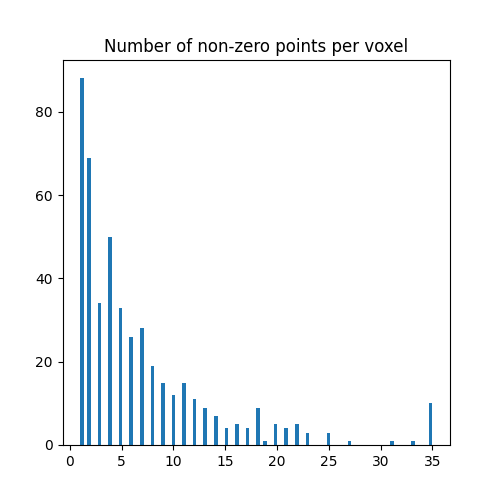

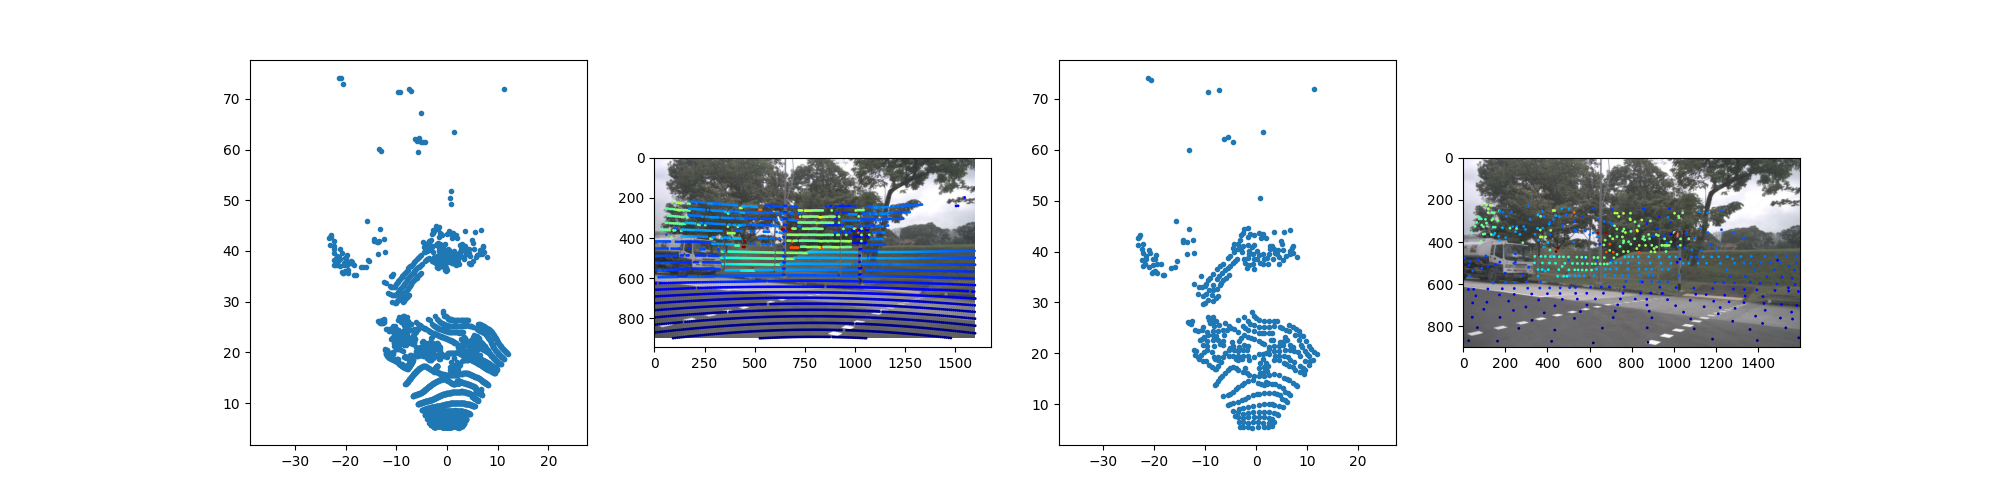

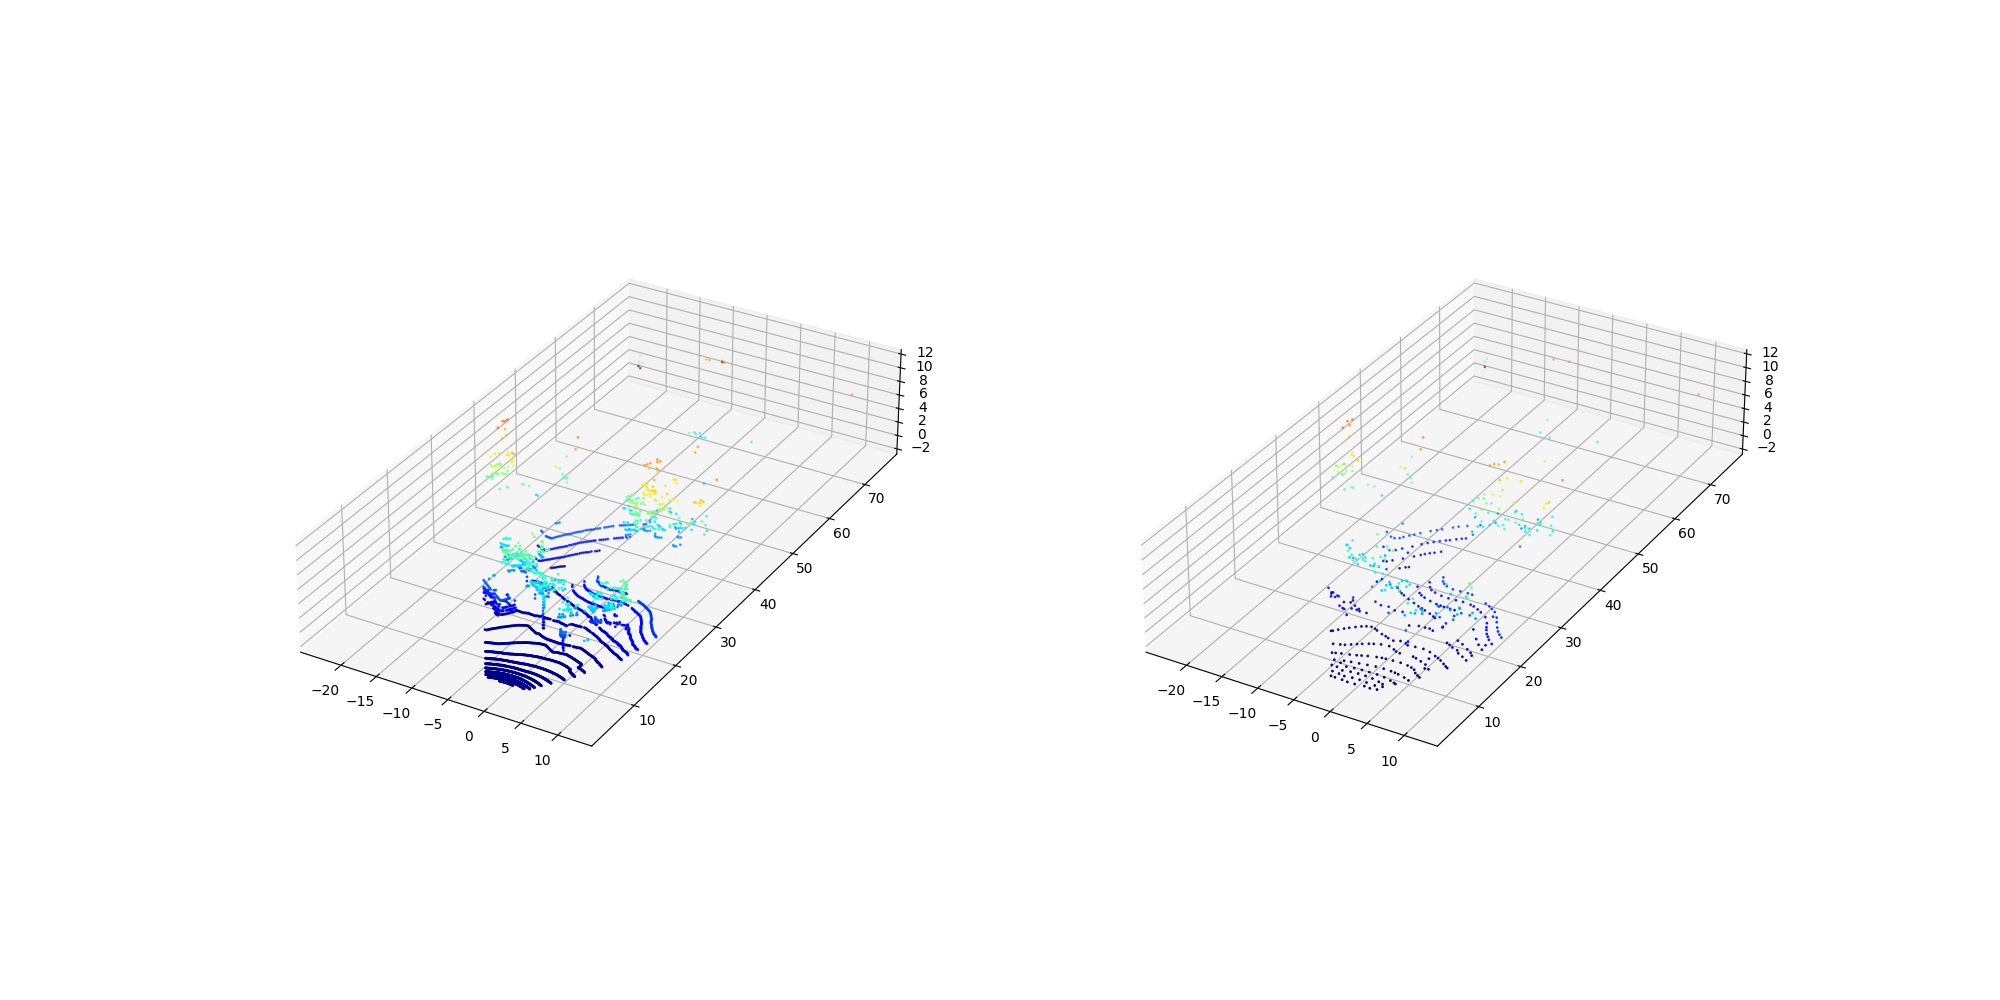

In [205]:
# Get number of non-zero points for each voxel
non_zero_points_per_voxel = [ sum([ point.any() for point in voxel ]) for voxel in voxels ]
plt.figure(figsize=(5, 5))
plt.hist(non_zero_points_per_voxel, bins=100)
plt.title("Number of non-zero points per voxel")
plt.show()

# Compute center of mass for each voxel
voxel_centroids = np.zeros((voxels.shape[0], 3))
for i, voxel in enumerate(voxels):
    voxel_mean_x = voxel[:, 0].sum() / non_zero_points_per_voxel[i]
    voxel_mean_y = voxel[:, 1].sum() / non_zero_points_per_voxel[i]
    voxel_mean_z = voxel[:, 2].sum() / non_zero_points_per_voxel[i]
    voxel_centroids[i, :] = [voxel_mean_x, voxel_mean_y, voxel_mean_z]


# Project voxel centroids to 2d
voxel_centroids_2d = proj_points_to_2d(voxel_centroids, proj_mat)


# Create subplot lidar points, projected lidar points, voxel centroids and projected voxel centroids
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot(points_3d_in_image[:, 0], points_3d_in_image[:, 1], ".")
ax[0].axis("equal")
ax[1].imshow(rgb)
ax[1].scatter(points_2d_in_image[:, 0], points_2d_in_image[:, 1], s=1, c=points_2d_in_image[:, 2], cmap="jet")
ax[2].plot(voxel_centroids[:, 0], voxel_centroids[:, 1], ".")
ax[2].axis("equal")
ax[3].imshow(rgb)
ax[3].scatter(voxel_centroids_2d[:, 0], voxel_centroids_2d[:, 1], s=1, c=voxel_centroids_2d[:, 2], cmap="jet")
plt.show()

# Create 3d plot of lidar points
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_3d_in_image[:, 0], points_3d_in_image[:, 1], points_3d_in_image[:, 2], s=1, c=points_3d_in_image[:, 2], cmap="jet")
ax.set_box_aspect((np.ptp(points_3d_in_image[:, 0]), np.ptp(points_3d_in_image[:, 1]), np.ptp(points_3d_in_image[:, 2])))

# Create 3d plot of voxel centroids
ax = fig.add_subplot(122, projection='3d')
ax.scatter(voxel_centroids[:, 0], voxel_centroids[:, 1], voxel_centroids[:, 2], s=1, c=voxel_centroids[:, 2], cmap="jet")
ax.set_box_aspect((np.ptp(voxel_centroids[:, 0]), np.ptp(voxel_centroids[:, 1]), np.ptp(voxel_centroids[:, 2])))
plt.show()


In [206]:
voxel_centroids.shape

(472, 3)

In [207]:
proj_mat

array([[ 1.27191393e+03,  8.07299084e+02,  2.46479956e+01,
        -4.84254271e+02],
       [ 1.25995546e+01,  5.15487591e+02, -1.25678380e+03,
        -7.03559265e+02],
       [ 6.81137362e-03,  9.99795043e-01,  1.90650872e-02,
        -6.02145212e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [208]:
tmp = np.array([0, 0, 0])

In [209]:
tmp = np.concatenate([tmp, [1]], axis=-1)
point_2d = tmp @ proj_mat.T
point_2d[2] = np.clip(point_2d[2], a_min=1e-5, a_max=1e5)

In [210]:
point_2d

array([-4.84254271e+02, -7.03559265e+02,  1.00000000e-05,  1.00000000e+00])

In [211]:
tmp

array([0, 0, 0, 1])

In [212]:
tmp.nonzero()

(array([3]),)

In [213]:
np.any(tmp)

True

In [214]:
tmp = np.zeros((5, 3))
#tmp[2, 1] = 2
#tmp[3, 0] = 3
#tmp[4, 2] = 2

In [215]:
tmp

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [216]:
tmp.nonzero()

(array([], dtype=int64), array([], dtype=int64))

In [217]:
# Get non-zero rows in tmp
tmp[tmp.any(axis=1)]

array([], shape=(0, 3), dtype=float64)

In [218]:
tmp

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [219]:
tmp.any()

False